In [1]:
!ls

README.md        main.ipynb       src
data             requirements.txt thrash


In [2]:
import torch
from matplotlib import pyplot as plt
from src.rl_algorithm.dqn.DQN_Agent import DQNAgent
import gym
from collections import deque
from gym.wrappers import RecordVideo
import src.util as util
from src.config import Config

In [3]:
# initial setup
util.seed_everything()                                # sets all the seeds
PATH_ROOT = util.make_all_paths(is_dynamic_root=True) # creates a path for testing 
util.write_json_to_file(dict(Config.__dict__), file_path=PATH_ROOT+"/config.json")  # store the information of simulation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('>> Using device:', device)

>> Created dir data/rl_class_11-27-2023_22-01-41/models
>> Created dir data/rl_class_11-27-2023_22-01-41/plots
>> Created dir data/rl_class_11-27-2023_22-01-41/videos
Error writing JSON data to data/rl_class_11-27-2023_22-01-41//config.json: Object of type getset_descriptor is not JSON serializable
>> Using device: cpu


In [4]:
agent = DQNAgent(frames=Config.N_FRAMES, action_space=Config.action_space, device=device, hidden_dimension=Config.HIDDEN_DIMENSION_FC)

In [5]:
# env = gym.make('CarRacing-v2', render_mode="human")  # , render_mode='human')
# 
# # chose each of thw available actions with probability 1/12 
# MAX_STEP = 1000
# env.reset()
# for step in range(MAX_STEP):
#     action = agent.act(is_only_random=True)
#     next_state, r, epi_done, info, _ = env.step(action)
# env.close()

In [6]:
# https://www.gymlibrary.dev/environments/box2d/car_racing/
env = gym.make('CarRacing-v2', render_mode="rgb_array")  # , render_mode='human')
env = RecordVideo(env, PATH_ROOT + 'videos', episode_trigger=lambda x: x % Config.UPDATE_TARGET_MODEL_FREQUENCY == 0)

/Users/matteoprata/opt/anaconda3/envs/rl_course/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/matteoprata/PycharmProjects/RL23/data/rl_class_11-27-2023_22-01-41/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [7]:
# episode stats
epi_total_rewards = []

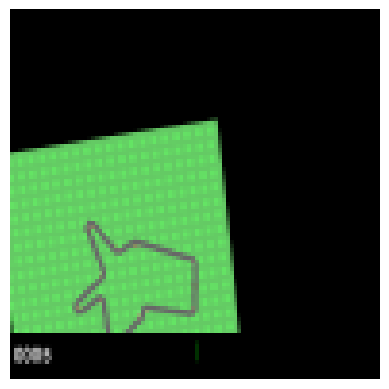

In [11]:
init_state = env.reset()[0]  # 96, 96, 3 pixels image RGB
util.plot_frame_car(init_state)

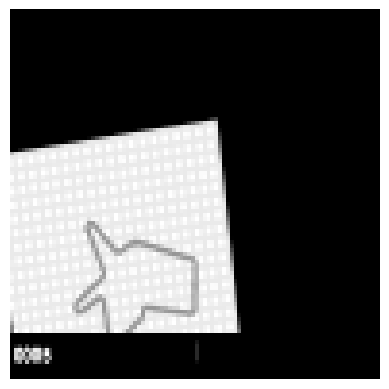

In [12]:
init_state = util.preprocess_frame_car(init_state)  # 96, 96 pixels image GRAY
util.plot_frame_car(init_state)

In [13]:
for e in range(Config.STARTING_EPISODE, Config.ENDING_EPISODE + 1):
    env.episode_id = e

    init_state = env.reset()[0]                         # 96, 96, 3 pixels image RGB
    init_state = util.preprocess_frame_car(init_state)  # 96, 96 pixels image GRAY

    epi_total_reward = 0
    epi_negative_reward_counter = 0
    epi_time_frame_counter = 1
    epi_done = False

    # (1) EVALUATE STATE: S
    state_queue = deque([init_state] * Config.N_FRAMES, maxlen=Config.N_FRAMES)
    state_tensor = torch.Tensor(state_queue).unsqueeze(0).to(device)
    # util.plot_state_car(np.array(state_queue))  # visualize S0

    while True:
        state_tensor = torch.Tensor(state_queue).unsqueeze(0).to(device)
        action = agent.act(state_tensor)

        # (2) EXECUTE ACTION (for several steps)
        # (3) EVALUATE S' STATE, REWARD
        reward = 0
        for _ in range(Config.SKIP_FRAMES):
            # execute action
            next_state, r, epi_done, _, _ = env.step(action)
            # util.plot_frame_car(next_state)
            reward += r
            if epi_done:
                break

        # (4) ADJUST REWARD
        # if getting negative reward 10 times after the tolerance steps, terminate this episode
        if epi_time_frame_counter > 100 and reward < 0:
            epi_negative_reward_counter += 1
        else:
            epi_negative_reward_counter = 0

        # extra bonus for the model if it uses full gas
        if action[1] == 1 and action[2] == 0:
            reward *= Config.GAS_WEIGHT

        epi_total_reward += reward

        # util.plot_state_car(np.array(state_queue), title="STATE 0")
        # process state S'
        next_state = util.preprocess_frame_car(next_state)
        next_state_queue = deque([frame for frame in state_queue], maxlen=Config.N_FRAMES)
        next_state_queue.append(next_state)
        # util.plot_state_car(np.array(next_state_queue), title="STATE 1")

        next_state_tensor = torch.Tensor(next_state_queue).unsqueeze(0).to(device)

        # (5) STORE OBSERVATIONS
        # Memorizing saving state, action reward tuples
        agent.memorize(state_tensor, action, reward, next_state_tensor, epi_done)

        # S = S'
        state_queue = next_state_queue

        # early stop if the number of
        if epi_negative_reward_counter >= 25 or epi_total_reward < 0:
            break

        # (6) TRAIN ON BATCHES OF OBSERVATIONS
        # train the model with tuple, if there are enough tuples
        if len(agent.memory) > Config.TRAINING_BATCH_SIZE:
            agent.replay(Config.TRAINING_BATCH_SIZE)

        epi_time_frame_counter += 1
    epi_total_rewards += [epi_total_reward]

    # >>> ON EPISODE END
    # print stats
    stats_string = 'Episode: {}/{}, Scores(Time Frames): {}, Total Rewards: {:.2}, Epsilon: {:.2}'
    print(stats_string.format(
        e,
        Config.ENDING_EPISODE,
        epi_time_frame_counter,
        float(epi_total_reward),
        float(agent.epsilon))
    )

    if e % Config.UPDATE_TARGET_MODEL_FREQUENCY == 0:
        # plot rewards stats
        plt.plot(epi_total_rewards, label="cum rew", color="blue")
        plt.title("Rewards during episode episode")
        plt.savefig(PATH_ROOT + 'plots/reward_{}.pdf'.format(e))

        # save model frequently
        agent.save_model(PATH_ROOT + 'models/trial_{}.h5'.format(e))

        # swap model
        agent.update_target_model()
        util.write_json_to_file({"CUM_REW": epi_total_rewards}, PATH_ROOT+"/stats.json")
    env.close()

/var/folders/dd/rff3hk2d6p79x89xcscm2zdm0000gn/T/ipykernel_62912/229970436.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  state_tensor = torch.Tensor(state_queue).unsqueeze(0).to(device)
/Users/matteoprata/opt/anaconda3/envs/rl_course/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/1000, Scores(Time Frames): 141, Total Rewards: -0.13, Epsilon: 0.99
Moviepy - Building video /Users/matteoprata/PycharmProjects/RL23/data/rl_class_11-27-2023_22-01-41/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/matteoprata/PycharmProjects/RL23/data/rl_class_11-27-2023_22-01-41/videos/rl-video-episode-0.mp4


Moviepy - Done !
Moviepy - video ready /Users/matteoprata/PycharmProjects/RL23/data/rl_class_11-27-2023_22-01-41/videos/rl-video-episode-0.mp4


KeyboardInterrupt: 